In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

import scoring as score # para hacer los reportes de puntajes
from time import time

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.preprocessing import RobustScaler  
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

properati = pd.read_csv('datos/properati_final.csv',error_bad_lines=False)
len (properati)

<IPython.core.display.Javascript object>

136356

In [62]:
properati.info()
properati=properati.loc[properati.price_aprox_usd<1e6]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136356 entries, 0 to 136355
Data columns (total 23 columns):
created_on                    136356 non-null object
property_type                 136356 non-null object
place_name                    136356 non-null object
state_name                    136356 non-null object
lat-lon                       136356 non-null object
lat                           96345 non-null float64
lon                           96345 non-null float64
price                         136356 non-null float64
currency                      136356 non-null object
price_aprox_local_currency    136356 non-null float64
price_aprox_usd               136356 non-null float64
surface_total_in_m2           136356 non-null float64
surface_covered_in_m2         136356 non-null float64
price_usd_per_m2              136356 non-null float64
price_per_m2                  136356 non-null float64
floor                         14295 non-null float64
rooms                         6963

In [63]:
properati.loc[:,('created_on')] = pd.to_datetime(properati['created_on'])
properati['anio'] = [x.year for x in properati['created_on'] ]

In [64]:
#paso features con strings a numericos
le_barrio = preprocessing.LabelEncoder()
barrios=properati['state_name']
le_barrio.fit(barrios)
properati['state_name'] = le_barrio.transform(barrios)

le_zona = preprocessing.LabelEncoder()
zona=properati['place_name']
le_zona.fit(zona)
properati['place_name'] = le_zona.transform(zona)

le_tipo = preprocessing.LabelEncoder()
tipos_prop=properati['property_type']
le_tipo.fit(tipos_prop)
properati['property_type'] = le_tipo.transform(tipos_prop)

# RF clasificador

In [65]:
cant_buckets = 200

#buckets
cantidad,rango = np.histogram(properati['price_usd_per_m2'], bins=cant_buckets)
properati['categories_by_price']=pd.cut(properati['price_usd_per_m2'],rango,labels=np.arange(cant_buckets),include_lowest=True)
properati['price_range']=pd.cut(properati['price_usd_per_m2'],rango)
#lo casteo a float porque si no tira error 
properati['categories_by_price']=properati['categories_by_price'].astype(np.float64) 
properati.groupby('categories_by_price').count().sort_values("lat",ascending=True)

,created_on,property_type,place_name,state_name,lat-lon,lat,lon,price,currency,price_aprox_local_currency,...,floor,rooms,expenses,properati_url,description,title,fecha,superficie_descubierta,anio,price_range
categories_by_price,,,,,,,,,,,,,,,,,,,,,
177.0,17,17,17,17,17,12,12,17,17,17,...,3,11,0,17,17,17,17,13,17,17
193.0,16,16,16,16,16,14,14,16,16,16,...,0,8,1,16,16,16,16,9,16,16
175.0,19,19,19,19,19,14,14,19,19,19,...,1,16,5,19,19,19,19,14,19,19
190.0,22,22,22,22,22,15,15,22,22,22,...,0,17,5,22,22,22,22,16,22,22
198.0,19,19,19,19,19,16,16,19,19,19,...,1,12,3,19,19,19,19,11,19,19
195.0,21,21,21,21,21,19,19,21,21,21,...,1,15,2,21,21,21,21,11,21,21
191.0,29,29,29,29,29,20,20,29,29,29,...,4,19,5,29,29,29,29,15,29,29
189.0,26,26,26,26,26,21,21,26,26,26,...,1,20,8,26,26,26,26,18,26,26
173.0,29,29,29,29,29,22,22,29,29,29,...,1,18,2,29,29,29,29,24,29,29


In [66]:
#preparo set de datos
X = [properati['surface_total_in_m2'],\
    properati['surface_covered_in_m2'],properati['property_type'],properati['state_name'],properati['place_name']]
y = properati['categories_by_price']

### Busco hiper-parametros con random search

In [67]:
%%notify

rf = RandomForestClassifier(n_jobs=-1)

oob_score=[True,False]
criterion = ['gini','entropy']
max_features =["auto","log2",None]
n_estimators = np.arange(10,100,10)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid = {"criterion": criterion,"max_features":max_features,"n_estimators":n_estimators,"oob_score":oob_score}

search = RandomizedSearchCV(rf, param_distributions=param_grid ,cv=5,n_iter=50) #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

ValueError: Found input variables with inconsistent numbers of samples: [5, 133199]

<IPython.core.display.Javascript object>

ValueError: Found input variables with inconsistent numbers of samples: [5, 133199]

In [ ]:
mejor_rf = search.best_estimator_
print mejor_rf.feature_importances_ # la importancia de cada feature (cuanta informacion le provee al rf) ordenado tal y cual esta zipeado el X

In [ ]:
search.score(X_test,y_test) # pruebo el estimador refiteado con el set de test

# RF Regresor

In [68]:
#preparo set de datos
X = zip(properati['surface_total_in_m2'],\
        properati['surface_covered_in_m2'],properati['property_type'],properati['state_name'],properati['place_name'])
y = properati['price_aprox_usd']
X=scaler.fit_transform(X,y)

In [69]:
%%notify

rf = RandomForestRegressor(n_jobs=-1)

criterion = ['mse']
max_features =["auto","log2",None]
n_estimators = np.arange(10,200,10)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid = {"criterion": criterion,"max_features":max_features,"n_estimators":n_estimators}

search = RandomizedSearchCV(rf, param_distributions=param_grid ,cv=5,n_iter=50) #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

### Hago GS en los mejores

In [79]:
%%notify

rf = RandomForestRegressor(n_jobs=-1)

criterion = ['mse']
max_features =['log2']
n_estimators = np.arange(30,70,5)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid = {"criterion": criterion,"max_features":max_features,"n_estimators":n_estimators}

search = GridSearchCV(rf, param_grid=param_grid ,cv=5,scoring="neg_mean_squared_error") #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

GridSearchCV duro 81.14 segundos para 8 candidatos a hiper-parametros.

Puesto: 1
Promedio training score: -1312228919.214 (std: 10229499.405)
Promedio validation score: -5499484242.024 (std: 96859896.947)
Promedio fit time: 1.683s
Hiper-parametros: {'max_features': 'log2', 'n_estimators': 65, 'criterion': 'mse'}

Puesto: 2
Promedio training score: -1313196602.394 (std: 10067063.968)
Promedio validation score: -5501465825.376 (std: 124554727.193)
Promedio fit time: 1.504s
Hiper-parametros: {'max_features': 'log2', 'n_estimators': 60, 'criterion': 'mse'}

Puesto: 3
Promedio training score: -1322137899.777 (std: 10187053.631)
Promedio validation score: -5504478038.542 (std: 115847342.067)
Promedio fit time: 1.438s
Hiper-parametros: {'max_features': 'log2', 'n_estimators': 50, 'criterion': 'mse'}

Puesto: 4
Promedio training score: -1318271582.611 (std: 8453239.540)
Promedio validation score: -5511618437.326 (std: 106583327.862)
Promedio fit time: 1.360s
Hiper-parametros: {'max_features':

<IPython.core.display.Javascript object>

In [80]:
mejor_rf = search.best_estimator_
print mejor_rf.feature_importances_ # la importancia de cada feature (cuanta informacion le provee al rf) ordenado tal y cual esta zipeado el X

[ 0.26422449  0.48184119  0.07624635  0.05670264  0.12098533]


In [81]:
search.score(X_test,y_test)

-5236988025.4976244

In [82]:
errores = mejor_rf.predict(X_test)-y_test
print ("Error maximo:{0}\nError minimo:{1}".format( max(abs(errores)),min(abs(errores))))
print(errores)

Error maximo:838742.319362
Error minimo:0.0
64414      13630.658799
125050      2196.591555
62410     -32743.984115
16220      24963.333333
4737       13430.769231
70941     -54684.615385
2530        7559.551282
67884      27306.950825
44165      49307.692308
104492    207404.334399
50714      -4161.590347
17600      25485.897436
83589      86648.205128
59263     -45218.461538
93223      -4068.046813
23567      71612.537964
77418      -1320.073260
51851       6843.396561
31938     -86415.384615
96279        657.712821
19788      -3644.542125
105877   -141587.179487
120860   -171081.794872
119729     -8571.340769
135749      6889.751795
96374      63613.001392
66905       -184.615385
5551        1879.132479
31863      -4841.529304
85749        355.750916
              ...      
92032      19869.743590
51612     -14853.040293
75310    -139537.698413
37005       2448.369231
82564       4315.384615
129386    -13576.871245
15451      -3493.338361
19489       3417.948718
112072    -71806.666

## Analsis de errores

In [77]:
count_max=0
max_error=50
lista=[]
for error in errores:
    if abs(error)>=max_error:
        count_max+=1
        lista.append(abs(error))
print ("Hay {0} de {1} que tienen mas de {2} USD de error ({3}%)".format(count_max,len(errores),max_error,100 * count_max/len(errores)))

Hay 26509 de 26640 que tienen mas de 50 USD de error (99%)


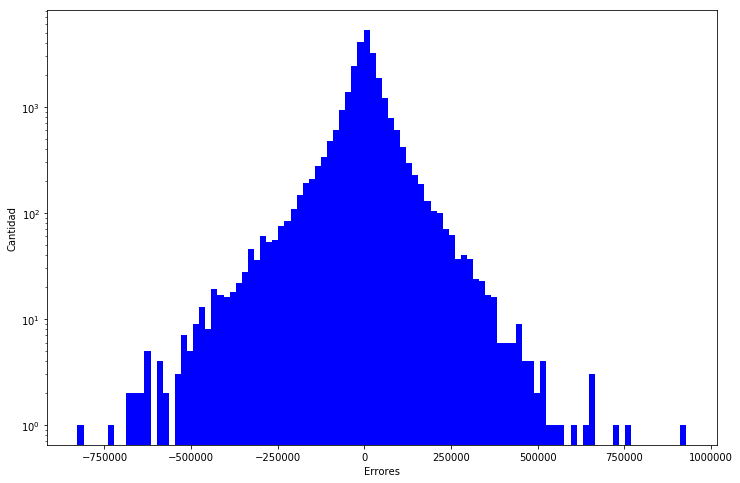

In [45]:
# the histogram of the data
plt.figure(figsize=(12,8))
plt.hist(errores, 100, facecolor='blue')
plt.xlabel('Errores')
plt.ylabel('Cantidad')
#plt.xlim(-1000, 1000) #para variar el "zoom a 0"
plt.yscale('log')
plt.show()

###  Distribucion de precios

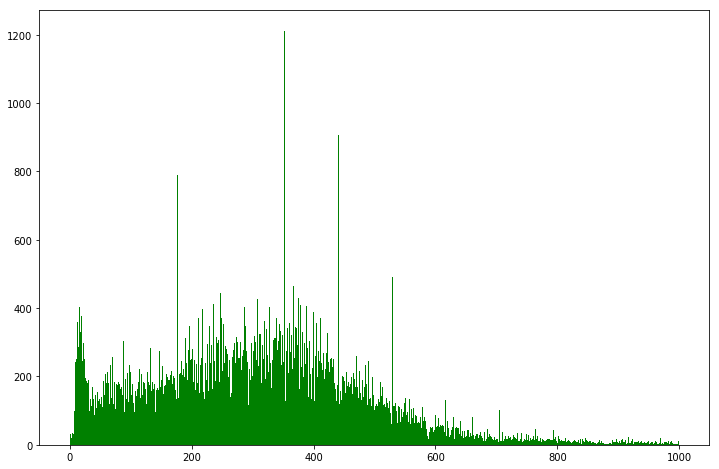

In [46]:
plt.figure(figsize=(12,8))
cant_buckets=1000
cantidad,rango = np.histogram(properati['price_usd_per_m2'], bins=cant_buckets)
properati['categories_by_price']=pd.cut(properati['price_usd_per_m2'],rango,labels=np.arange(cant_buckets),include_lowest=True)
plt.hist(properati.categories_by_price,cant_buckets,facecolor='green')
plt.show()

## Pruebo reduccion con RF

In [5]:
X = zip(properati['dist_a_subte'],properati['dist_a_univ'],properati['dist_a_tren'],properati['dist_a_villa'],\
        properati['dist_a_zona_anegada'],properati['surface_total_in_m2'],\
        properati['surface_covered_in_m2'],properati['lat'],properati['lon'])

y = properati['price_aprox_usd']

X=scaler.fit_transform(X,y)

In [8]:
%%notify

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

estimators = [('pca', PCA()), ('rf', RandomForestRegressor())]
pipe = Pipeline(estimators)

criterion = ['mse']
max_features =['log2']
n_estimators = np.arange(170,200,10)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid= dict( pca__n_components=np.arange(1,8,1),rf__criterion = criterion,
rf__max_features =max_features,
rf__n_estimators = n_estimators)

grid_search = GridSearchCV(pipe, param_grid=param_grid,n_jobs=-1,refit=True,cv=5)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease...timators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'rf__n_estimators': array([170, 180, 190]), 'pca__n_components': array([1, 2, 3, 4, 5, 6, 7]), 'rf__criterion': ['mse'], 'rf__max_features': ['log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

<IPython.core.display.Javascript object>

In [9]:
grid_search.best_estimator_.score(X_test,y_test)

0.88303320656392525

In [10]:
estimador_pipe=grid_search.best_estimator_
estimador_pipe

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=7, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0....imators=170, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])

In [11]:
estimador_pipe.get_params
estimador_pipe.steps[1][1].feature_importances_

array([ 0.56243461,  0.09539613,  0.05607901,  0.12204571,  0.06051094,
        0.04868756,  0.05484603])

In [12]:
errores = estimador_pipe.predict(X_test)-y_test

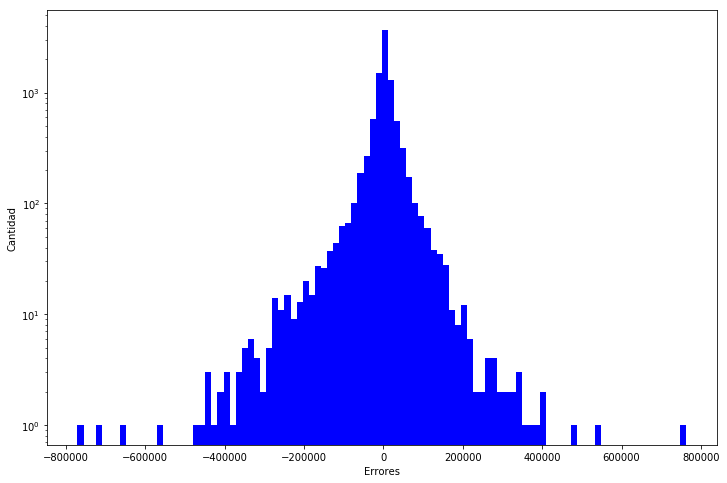

In [13]:
# the histogram of the data
plt.figure(figsize=(12,8))
plt.hist(errores, 100, facecolor='blue')
plt.xlabel('Errores')
plt.ylabel('Cantidad')
#plt.xlim(-1000, 1000) #para variar el "zoom a 0"
plt.yscale('log')
plt.show()